<a href="https://colab.research.google.com/github/ikram-hamizi/AML-DS-2021/blob/main/AML_Lab9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Week 9 : Generative Adversarial Networks
```
- Advanced Machine Learning, Innopolis University 
- Professor: Muhammad Fahim 
- Teaching Assistant: Gcinizwe Dlamini
```
<hr>


```
Lab Plan
    1. Homework 1 Feedback
    2. Recap Auto-encoder
    3. Vanila GAN
```

<hr>

## 1. Autoencoders (Recap)

* Types of autoencoders
* Applications of autoencoders
* Autoencoders training procedure


![caption](https://miro.medium.com/max/2400/1*Q5dogodt3wzKKktE0v3dMQ@2x.png)

### 1.2 Simple autoencoder

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
class autoencoder(nn.Module):
    def __init__(self, flattened_input_size, latent_dim):
      super(autoencoder, self).__init__()

      # Step 1 : Define the encoder 
      self.encoder = nn.Sequential(
          nn.Linear(flattened_input_size, flattened_input_size//2),
          nn.ReLU(True),
          nn.Linear(flattened_input_size//2, flattened_input_size//3),
          nn.Linear(flattened_input_size//3, flattened_input_size//4),
          nn.Tanh(),  
          nn.Linear(flattened_input_size//4, latent_dim)
          )

      # Step 2 : Define the decoder
      self.decoder = nn.Sequential(
          nn.Linear(latent_dim, flattened_input_size//4),
          nn.Tanh(),
          nn.Linear(flattened_input_size//4, flattened_input_size//3),
          nn.Linear(flattened_input_size//3, flattened_input_size//2),
          nn.ReLU(True),  
          nn.Linear(flattened_input_size//2, flattened_input_size)
          )
        
      # Step 3 : Initialize the weights (optional)
      self.encoder.apply(self.__init_weights)
      self.decoder.apply(self.__init_weights)

    def forward(self, x):
        # Step 1: Pass the input through encoder to get latent representation
        # Step 2: Take latent representation and pass through decoder
        return self.decoder(self.encoder(x))
    
    def encode(self,input):
        #Step 1: Pass the input through the encoder to get latent representation
        return self.encoder(input)
    
    def __init_weights(self,m):
        #Init the weights (optional)
        if type(m) == nn.Linear:
          torch.nn.init.xavier_uniform_(m.weight)
          m.bias.data.fill_(0.01)
        pass

### 1.3 Train autoencoder 

In [ ]:
# Step 1: Set training parameters (batch size, learning rate, number of epochs, loss function)
batch_size = 64
lr = 1e-2
num_epochs = 20
criterion = nn.MSELoss()

# Step 2: Create dataset (Randomly generated)
data = torch.randn((batch_size, 1, 8, 8))

# Step 3: Define optimizer + model
auto_encoder = autoencoder(8*8, 5).to(device)
optimizer = torch.optim.Adam(auto_encoder.parameters(), lr=lr)

# Step 4: Create data loader 
data_loader = DataLoader(TensorDataset(torch.randn(1000, 1, 8, 8)), batch_size=32, shuffle=True)

In [ ]:
# Step 5: Define the training loop
for epoch in range(num_epochs):
  epoch_loss = 0.0
  for img in data_loader:
    img = img[0].to(device)
    img = img.reshape(-1, 8*8) #flatten our images (1, 28,28) => (1,784)
    reconstructed = auto_encoder(img)
    
    #forward
    loss = criterion(reconstructed, img) #MSE loss
    optimizer.zero_grad()

    #backward
    loss.backward() 
    optimizer.step()
  
  print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():-4f}")

Epoch 1/20, Loss: 1.060658
Epoch 2/20, Loss: 0.990558
Epoch 3/20, Loss: 0.958569
Epoch 4/20, Loss: 0.851346
Epoch 5/20, Loss: 0.908715
Epoch 6/20, Loss: 0.955607
Epoch 7/20, Loss: 0.908401
Epoch 8/20, Loss: 0.907450
Epoch 9/20, Loss: 0.859192
Epoch 10/20, Loss: 0.875163
Epoch 11/20, Loss: 0.926998
Epoch 12/20, Loss: 1.014086
Epoch 13/20, Loss: 0.907662
Epoch 14/20, Loss: 0.885398
Epoch 15/20, Loss: 0.783123
Epoch 16/20, Loss: 0.929898
Epoch 17/20, Loss: 0.865558
Epoch 18/20, Loss: 0.925156
Epoch 19/20, Loss: 0.818079
Epoch 20/20, Loss: 0.904466


In [ ]:
for a in data_loader:
  print(a[0].shape)
  break

torch.Size([32, 1, 8, 8])


## 2. Vannila Generative adversarial network (GAN)

![caption](https://www.researchgate.net/profile/Zhaoqing-Pan/publication/331756737/figure/fig1/AS:736526694621184@1552613056409/The-architecture-of-generative-adversarial-networks.png)

### 2.1 Dataset 

For this lesson we will use SVHN dataset which readily available in `torchvision` and we will do minimal transformation operations (Street View House Number)

In [ ]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets
from torchvision import transforms

def normalize(data_tensor):
    '''re-scale image values to [-1, 1]'''
    return (data_tensor / 255.) * 2. - 1.
    
def denorm(scaled_data_tensor):
    '''re-scale image values back to [0, 255]'''
    return (scaled_data_tensor + 1) * 255. / 2.

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize(64),
                                transforms.Lambda(lambda x: normalize(x))])

# SVHN training datasets
svhn_train = datasets.SVHN(root='data/', split='train', download=True, transform=transform)

batch_size = 128
num_workers = 2

# build DataLoaders for SVHN dataset
train_loader = torch.utils.data.DataLoader(dataset=svhn_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers)

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print("Image shape:", images.shape, images[0].shape)
print("min and max values in the data", torch.min(images), torch.max(images))

Image shape: torch.Size([128, 3, 64, 64]) torch.Size([3, 64, 64])
min and max values in the data tensor(-1.) tensor(-0.9922)


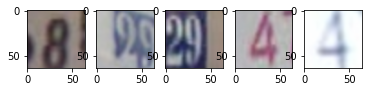

In [ ]:
for i in range(5):
  img = images[i]
  img = denorm(img.detach()) #denormalize
  img = img.permute(1, 2, 0) #reshape back
  plt.subplot(1,5,i+1)
  plt.imshow(img)

## 2.2 Generator & Discriminator Definition

There are a couple of ways to increase the input of the generator (*z*) to the desired output size.
1. Number of neurones
2. Transposed Convolutions `torch.nn.ConvTranspose2d` [More info](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Discriminator(nn.Module):

    def __init__(self, n_filters=3, conv_dim=32): 
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            
            #  Conv2d(in_channels, out_channels, kernel_size)
            #in: B, 3, 64, 64
            nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False), #why bias=False ?
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            #out: B, 64, 32 , 32

            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),    
            #out: B, 128, 16 , 16

            nn.Conv2d(128, 256 , 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: B, 512 , 8 , 8 

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: B, 512 , 4 , 4

            nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=0, bias=False),
            #out: B, 1 , 1 , 1
            nn.Flatten()
            # nn.Sigmoid()
            )

    def forward(self, x):
        # Step 1: pass the input (real or fake samples) through all hidden layers
        return self.model(x)

class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()
        # Step 1: Define the generator network architecture
        # NOTE: the input is the random noise size and output is conv_dim i.e (3,32,32)
      
        
        self.input_to_linear = nn.Linear(z_size, 2048, bias=False)

        
        self.model = nn.Sequential(
            
            # out = (w​−1)*s − 2P + f + out_P
            #  ConvTranspose2d(in_channels, out_channels, kernel_size)
            
            # in: B, 2048 , 1 , 1
            nn.ConvTranspose2d(2048, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # out: B, 512 , 4 , 4

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # out: B, 256 , 8 , 8 (4*stride=8)

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # out: B, 128 , 16 , 16

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # out: B,64 , 32 , 23

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # out: B, 3 , 64 , 64
        )
        

    def forward(self, x):
        # Step 1: pass the input which is random noise to generate the face samples
        x = self.input_to_linear(x)
        # x = x.view(-1, 128, 4, 4)
        x = x.view(-1, 2048, 1, 1)
        return self.model(x)

In [ ]:
#Gci04
import torch.nn as nn
import torch.nn.functional as F
#ngf : Number of generator filters
#ndf : Number of discriminator filters
nz = 32
class Discriminator(nn.Module):

    def __init__(self, ndf=3, conv_dim=32):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, 1, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1),
            nn.Flatten(),
            nn.Linear(5*5,1),
            nn.Sigmoid()
          )
        

    def forward(self, x):
        # Step 1: pass the input (real or fake samples) through all hidden layers
        return self.model(x)

class Generator(nn.Module):
    
    def __init__(self, z_size, ngf, conv_dim=32):
        super(Generator, self).__init__()
        # Step 1: Define the generator network architecture
        # NOTE: the input is the random noise size and output is conv_dim i.e (3,32,32)
        self.conv_dim = conv_dim 
        self.input_layer = nn.Linear(in_features=z_size, out_features=2048, bias=True)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 128, out_channels=ngf * 2, kernel_size=4,stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features= ngf * 2),
            nn.Tanh(),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_features=ngf),
            nn.Tanh(),
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        

    def forward(self, x):
      # Step 1: pass the input which is random noise to generate the face samples
      x = self.input_layer(x)
      x = x.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
      return self.model(x)


## 2.3 Set hyperparams and training parameters

In [ ]:
# define hyperparams
conv_dim = 32
z_size = 100
num_epochs = 50

# define discriminator and generator
D = Discriminator(conv_dim).to(device)
G = Generator(z_size=z_size, conv_dim=conv_dim).to(device)

#print the models summary 
print(D); print()
print(G)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kernel_size=

## 2.4 Define the loss function for D(x) and G(x)

In [ ]:
import torch.optim as optim

def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels
        labels = torch.FloatTensor(batch_size).uniform_(0.9, 1).to(device)
    else:
        labels = torch.ones(batch_size).to(device) # real labels = 1     
    
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.FloatTensor(batch_size).uniform_(0, 0.1).to(device) # fake labels approx 0
    labels = labels.to(device)
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

# params
# learning_rate = 0.0003
beta1=0.5
beta2=0.999 # default value

d_learning_rate = 0.002
g_learning_rate = 0.0002


# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=(beta1, beta2))
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=(beta1, beta2))

## 2.5 GAN training Loop

In [ ]:
from torchvision.utils import save_image
import os 

dir = 'generated'
os.makedirs(dir, exist_ok=True)

def save_samples(file_number, latent_tensors):
    # 1. Generate a batch of fake images from latent tensors  
    fake_images = G(latent_tensors)
    fake_fname = 'generated-image-{}.png'.format(file_number)

    # 2. "save_image": Convert batch of images into a grid + save as png
    save_image(denorm(fake_images), os.path.join(dir, fake_fname), nrow=8)

In [ ]:
fixed_z = torch.FloatTensor(64, z_size).uniform_(-1, 1).to(device)
save_samples(0, fixed_z) #example

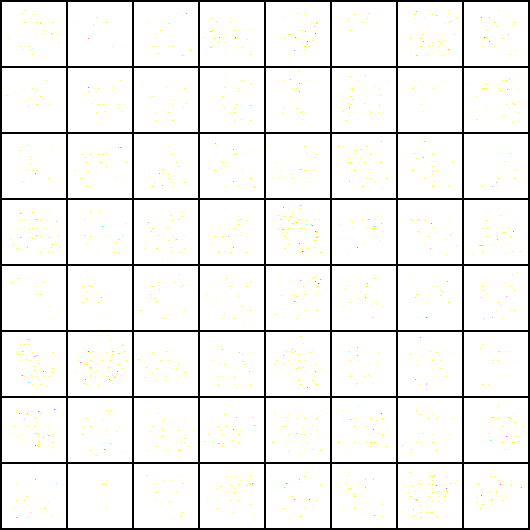

In [ ]:
from IPython.display import Image
Image("./generated/generated-image-0.png")

In [ ]:
from tqdm.notebook import tqdm
torch.cuda.empty_cache() #remove data from GPU memory

# keep track of loss and generated, "fake" samples
#losses_g = []
#losses_d = []

print_every = 1

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=64
fixed_z = torch.FloatTensor(sample_size, z_size).uniform_(-1, 1).to(device)
# fixed_z = torch.FloatTensor(sample_size, z_size,1, 1).uniform_(-1, 1).to(device)
# fixed_z = torch.empty(sample_size, z_size, 1,1).normal_(mean=0, std=1/4).to(device)
# fixed_z = torch.randn(sample_size, z_size, 1,1).to(device)
                                                      
# train the network
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in tqdm(enumerate(train_loader)):
                
        batch_size = real_images.size(0)    
        real_images = real_images.to(device)

        ''' TRAIN THE DISCRIMINATOR '''
        # Step 1: Zero gradients (zero_grad)
        d_optimizer.zero_grad()

        # Step 2: Train with real images
        D_real_preds = D(real_images) #y_preds
        d_real_score = torch.mean(nn.Sigmoid()(D_real_preds)).item() #should be 1 #FOR PRINTING ONLY
 
        # Step 3: Compute the discriminator losses on real images 
        d_real_loss = real_loss(D_real_preds)

        # Step 4: Train with fake images
        # z = torch.empty(batch_size, z_size, 1,1).normal_(mean=0, std=1/4).to(device)
        # z = torch.randn(batch_size, z_size, 1,1).to(device)
        z = torch.FloatTensor(batch_size, z_size).uniform_(-1, 1).to(device)

        # Step 5: Generate fake images and move x to GPU, if available
        fake_images = G(z)
        D_fake_preds = D(fake_images) #y_preds
        d_fake_score = torch.mean(nn.Sigmoid()(D_fake_preds)).item() #should be 0 #FOR PRINTING ONLY #(if more, G is getting better)

        # Step 6: Compute the discriminator losses on fake images 
        d_fake_loss = fake_loss(D_fake_preds)
        
        # Step 7: add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
                
        
        ''' TRAIN THE GENERATOR (Train with fake images and flipped labels)'''
                
        # Step 1: Zero gradients  
        g_optimizer.zero_grad()

        # Step 2: Generate fake images from random noise (z)
        # z = torch.empty(batch_size, z_size, 1,1).normal_(mean=0, std=1/4).to(device)
        # z = torch.randn(batch_size, z_size, 1,1).to(device)
        z = torch.FloatTensor(batch_size, z_size).uniform_(-1, 1).to(device)
        fake_images = G(z)

        # Step 3: Compute the discriminator losses on fake images using flipped labels!
        D_tricked_preds = D(fake_images) #y_preds
        d_tricked_loss = real_loss(D_tricked_preds) #trick it!
        

        # Step 4: Perform backprop and take optimizer step
        d_tricked_loss.backward()
        g_optimizer.step()
        
        #losses_d.append(d_loss)
        #losses_g.append(d_tricked_loss)

    # Print some loss stats
    if epoch % print_every == 0:
        print(f"Epoch {epoch}/{num_epochs}, loss_D: {d_loss:.4}, loss_G: {d_tricked_loss}, fake_score: {d_fake_score}, real_score: {d_real_score}")
        save_samples(epoch+1, fixed_z)


Epoch 0/50, loss_D: 0.1941, loss_G: 2.8772497177124023, fake_score: 0.07033956050872803, real_score: 0.9999653697013855



Epoch 1/50, loss_D: 0.4028, loss_G: 11.589962005615234, fake_score: 0.2548206150531769, real_score: 0.9999999403953552



Epoch 2/50, loss_D: 1.054, loss_G: 1.040384292602539, fake_score: 0.3020676374435425, real_score: 0.5307832956314087



Epoch 3/50, loss_D: 1.422, loss_G: 0.9463760852813721, fake_score: 0.6867121458053589, real_score: 0.7441660165786743



Epoch 4/50, loss_D: 1.523, loss_G: 0.3284112513065338, fake_score: 0.22783683240413666, real_score: 0.30251356959342957



Epoch 5/50, loss_D: 1.501, loss_G: 0.5600651502609253, fake_score: 0.3358555734157562, real_score: 0.3535236716270447



Epoch 6/50, loss_D: 1.14, loss_G: 0.7255484461784363, fake_score: 0.3772503733634949, real_score: 0.5369307398796082



Epoch 7/50, loss_D: 1.229, loss_G: 1.1301047801971436, fake_score: 0.5258223414421082, real_score: 0.6482177972793579



Epoch 8/50, loss_D: 1.478, loss_G: 0.564566969871521, fake_score: 0.3043724000453949, real_score: 0.36661389470100403



Epoch 9/50, loss_D: 1.204, loss_G: 0.7036493420600891, fake_score: 0.38109830021858215, real_score: 0.5308903455734253



Epoch 10/50, loss_D: 1.211, loss_G: 0.8897587656974792, fake_score: 0.394817054271698, real_score: 0.5390099883079529



Epoch 11/50, loss_D: 1.31, loss_G: 1.3744704723358154, fake_score: 0.6364466547966003, real_score: 0.7925276160240173



Epoch 12/50, loss_D: 1.022, loss_G: 2.6084494590759277, fake_score: 0.5296632647514343, real_score: 0.8205873966217041



Epoch 13/50, loss_D: 0.2152, loss_G: 2.4107108116149902, fake_score: 0.10497090220451355, real_score: 0.9937451481819153



Epoch 14/50, loss_D: 0.2147, loss_G: 2.898702383041382, fake_score: 0.053376637399196625, real_score: 0.9994089603424072



Epoch 15/50, loss_D: 0.2106, loss_G: 2.915971517562866, fake_score: 0.04967353865504265, real_score: 0.9996852874755859



Epoch 16/50, loss_D: 0.1998, loss_G: 3.8302130699157715, fake_score: 0.04170428588986397, real_score: 0.9959762692451477



Epoch 17/50, loss_D: 0.1822, loss_G: 2.9902098178863525, fake_score: 0.0521373488008976, real_score: 0.9986937642097473



Epoch 18/50, loss_D: 0.1926, loss_G: 2.8070130348205566, fake_score: 0.07062052190303802, real_score: 0.999101996421814



Epoch 19/50, loss_D: 0.1977, loss_G: 3.007540225982666, fake_score: 0.050725970417261124, real_score: 0.9996086955070496



Epoch 20/50, loss_D: 0.1931, loss_G: 3.040924072265625, fake_score: 0.048261936753988266, real_score: 0.9997050166130066



Epoch 21/50, loss_D: 0.1862, loss_G: 2.8585777282714844, fake_score: 0.04870018735527992, real_score: 0.9984841346740723



Epoch 22/50, loss_D: 0.2188, loss_G: 2.812913656234741, fake_score: 0.09515304118394852, real_score: 0.9991570115089417



Epoch 23/50, loss_D: 0.2046, loss_G: 2.8830533027648926, fake_score: 0.06758283823728561, real_score: 0.9995760917663574



Epoch 24/50, loss_D: 0.1905, loss_G: 3.1652700901031494, fake_score: 0.04704719036817551, real_score: 0.9998337626457214



Epoch 25/50, loss_D: 0.2206, loss_G: 2.849919557571411, fake_score: 0.0352831706404686, real_score: 0.9999054074287415



Epoch 26/50, loss_D: 0.2007, loss_G: 3.202761650085449, fake_score: 0.02235763520002365, real_score: 0.9998267292976379



Epoch 27/50, loss_D: 0.2231, loss_G: 2.9165072441101074, fake_score: 0.055781085044145584, real_score: 0.9999664425849915



Epoch 28/50, loss_D: 0.2212, loss_G: 2.6283836364746094, fake_score: 0.048609256744384766, real_score: 0.9999304413795471



Epoch 29/50, loss_D: 0.2043, loss_G: 2.9290356636047363, fake_score: 0.04524809867143631, real_score: 0.9999601244926453



Epoch 30/50, loss_D: 0.2006, loss_G: 3.0508878231048584, fake_score: 0.0391119047999382, real_score: 0.9999262690544128



Epoch 31/50, loss_D: 0.1928, loss_G: 2.927272081375122, fake_score: 0.04160292074084282, real_score: 0.9999596476554871



Epoch 32/50, loss_D: 0.2118, loss_G: 2.744055986404419, fake_score: 0.06521524488925934, real_score: 0.9998944401741028



Epoch 33/50, loss_D: 0.2163, loss_G: 2.777930498123169, fake_score: 0.06469673663377762, real_score: 0.9987307786941528



Epoch 34/50, loss_D: 0.2129, loss_G: 3.3764705657958984, fake_score: 0.03030833788216114, real_score: 0.9993165731430054



Epoch 35/50, loss_D: 0.212, loss_G: 3.512946128845215, fake_score: 0.019321255385875702, real_score: 0.999530017375946



Epoch 36/50, loss_D: 0.2222, loss_G: 2.9511823654174805, fake_score: 0.052371010184288025, real_score: 0.9998871684074402



Epoch 37/50, loss_D: 0.2295, loss_G: 2.9100799560546875, fake_score: 0.05085621774196625, real_score: 0.9998579621315002



Epoch 38/50, loss_D: 0.1762, loss_G: 3.1321418285369873, fake_score: 0.05034194141626358, real_score: 0.9998589754104614



Epoch 39/50, loss_D: 0.1968, loss_G: 2.905015707015991, fake_score: 0.060024991631507874, real_score: 0.9998849630355835



Epoch 40/50, loss_D: 0.2349, loss_G: 2.8390896320343018, fake_score: 0.037929024547338486, real_score: 0.9999141693115234



Epoch 41/50, loss_D: 0.2384, loss_G: 3.791710376739502, fake_score: 0.016422847285866737, real_score: 0.9982210993766785



Epoch 42/50, loss_D: 0.2214, loss_G: 4.176997184753418, fake_score: 0.011201644316315651, real_score: 0.9992059469223022



Epoch 43/50, loss_D: 0.213, loss_G: 3.23836088180542, fake_score: 0.04308413714170456, real_score: 0.9993491172790527



Epoch 44/50, loss_D: 0.2038, loss_G: 2.935492753982544, fake_score: 0.052300531417131424, real_score: 0.9999181032180786



Epoch 45/50, loss_D: 0.1964, loss_G: 2.878278970718384, fake_score: 0.04242778941988945, real_score: 0.9999255537986755



Epoch 46/50, loss_D: 0.1712, loss_G: 3.19689679145813, fake_score: 0.05168306827545166, real_score: 0.9999526143074036



Epoch 47/50, loss_D: 0.1902, loss_G: 3.04116153717041, fake_score: 0.04669876769185066, real_score: 0.9999789595603943



Epoch 48/50, loss_D: 0.1934, loss_G: 3.1749017238616943, fake_score: 0.04749360308051109, real_score: 0.9999467134475708



Epoch 49/50, loss_D: 0.1742, loss_G: 3.1601762771606445, fake_score: 0.047125302255153656, real_score: 0.9999784827232361


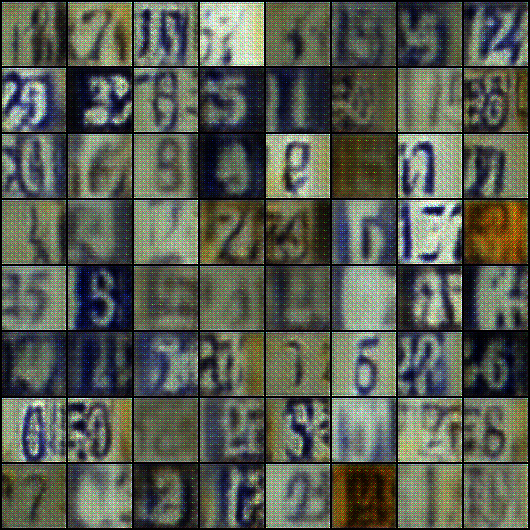

In [ ]:
Image("./generated/generated-image-13.png") #best possible

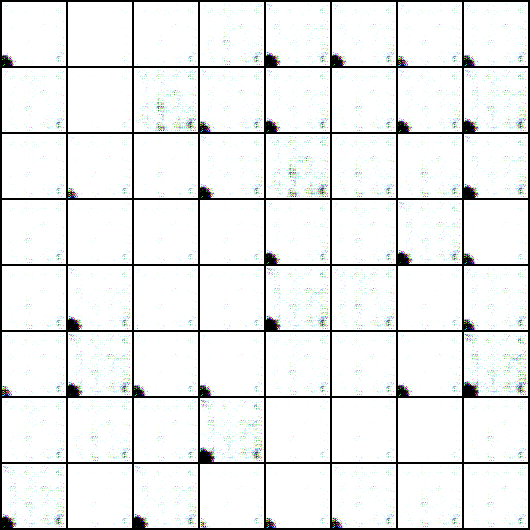

In [ ]:
Image("./generated/generated-image-43.png") #becomes noise again

Keep in mind:

1. Always use a learning rate for discriminator higher than the generator.

2. Keep training even if you see that the losses are going up.

3. There are many variations with different loss functions which are worth exploring.

4. If you get mode collapse, lower the learning rates.

5. Adding noise to the training data helps make the model more stable.

6. Label Smoothing: instead of making the labels as 1 make it 0.9 


## References
1. [Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

2. [Intuitively Understanding Variational Autoencoders](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)

3. [Tutorial - What is a variational autoencoder?](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)

4. [The variational auto-encoder](https://ermongroup.github.io/cs228-notes/extras/vae/)

5. [An Introduction to Variational Autoencoders](https://arxiv.org/abs/1906.02691)

6. [Basic VAE Example](https://github.com/pytorch/examples/tree/master/vae)

7. [Deep Convolutional Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan)

8. [Generative adversarial networks: What GANs are and how they’ve evolved](https://venturebeat.com/2019/12/26/gan-generative-adversarial-network-explainer-ai-machine-learning/)

9. [Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)

10. [GANs by google](https://developers.google.com/machine-learning/gan)

11. [A Gentle Introduction to Generative Adversarial Networks (GANs)](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/)

12. [A Beginner's Guide to Generative Adversarial Networks (GANs)](https://pathmind.com/wiki/generative-adversarial-network-gan)

13. [Understanding Generative Adversarial Networks (GANs)](https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29)

14. [Deep Learning (PyTorch)](https://github.com/udacity/deep-learning-v2-pytorch)

15. [10 Lessons I Learned Training GANs for one Year](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)

In [ ]:
#  self.model = nn.Sequential(
#             #  ConvTranspose2d(in_channels, out_channels, kernel_size)
#             # out = (w​−1)*s − 2P + f + out_P

#             # #in: B, z_size, 1, 1 
#             # nn.ConvTranspose2d(128, 512, kernel_size=4, stride=2, padding=0, bias=False), # (1-1)2 - 2*0 + 4 + 0 = 4
#             # nn.BatchNorm2d(512),
#             # nn.Tanh(),
            
#             # #out: B, 512, 4, 4
            
#             nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),    # (4-1)2 - 2*1 + 4 + 0 = 8
#             nn.BatchNorm2d(256),
#             nn.Tanh(),
#             #out: B, 256, 8, 8

#             nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),    # (8-1)2 - 2*1 + 4 + 0 = 16
#             nn.BatchNorm2d(128),
#             nn.Tanh(),
#             #out: B, 128, 16, 16

#             nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1, bias=False),    # (16-1)2 - 2*1 + 4 + 0 = 32
#             #out: B, 3, 32, 32

#             nn.Tanh() #because we 

import torch.nn as nn
import torch.nn.functional as F


class Discriminator(nn.Module):

    def __init__(self, n_filters=3, conv_dim=32): 
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            
            #  Conv2d(in_channels, out_channels, kernel_size)
            #in: B, 3, 32, 32
            nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False), #why bias=False ?
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            #out: B, 64, 16, 16

            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),    
            #out: B, 128, 8, 8

            nn.Conv2d(128, 1 , 1, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1),
            #out: B, 1, 5, 5 (image reduced to one pixel)

            nn.Flatten(),
            nn.Linear(5*5, 1),
            #nn.Sigmoid() #to output probabilities (fake or real)
        )

    def forward(self, x):
        # Step 1: pass the input (real or fake samples) through all hidden layers
        return self.model(x)

class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()
        # Step 1: Define the generator network architecture
        # NOTE: the input is the random noise size and output is conv_dim i.e (3,32,32)

        self.input_to_linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(z_size, 1024))
        
        self.model = nn.Sequential(
            #  ConvTranspose2d(in_channels, out_channels, kernel_size)
            # out = (w​−1)*s − 2P + f + out_P

            #in: B, z_size, 1, 1 
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=0, bias=False), # (1-1)2 - 2*0 + 4 + 0 = 4
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            #out: B, 512, 4, 4

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),    # (4-1)2 - 2*1 + 4 + 0 = 8
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            #out: B, 256, 8, 8

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),    # (8-1)2 - 2*1 + 4 + 0 = 16
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            #out: B, 128, 16, 16

            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1, bias=False),    # (16-1)2 - 2*1 + 4 + 0 = 32
            #out: B, 3, 32, 32

            nn.Tanh() #because we want to create images with values between [-1,1]
        )
        

    def forward(self, x):
        # Step 1: pass the input which is random noise to generate the face samples
        x = self.input_to_linear(x)
        x = x.view(-1, 1024, 1, 1)
        return self.model(x)